In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pip install -q decorator==5.0.9
!pip install -q ipywidgets

import csv
import math
import re
import imp
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q cltk==1.0.22
%pip install -q strsim
%pip install -q leven

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
# importing local modules

import sys
sys.path.append('../src/')

import text_cleanup.text_cleanup as thesisCleanUp
import preprocessing.text_preprocessing as thesisTextPreprocessing
import data.reader as thesisDataReader
import utils.utils as thesisUtils
import features.tf_idf.n_gram as thesisTfIdfNgramFeatures
import features.count_vectorizer.n_gram as thesisCountVectorizerNgramFeatures
import similarities.cosine as thesisCosineSimilarities
import similarities.levenshtein as thesisLevenshteinSimilarities
import vocabulary.vocabulary as thesisVocabulary
import features.lexical as thesisLexicalFeatures
import similarities.cosine as thesisCosineSimilarity
import text_cleanup.text_cleanup as thesisTextCleanUp
import p_aligment.p_aligment as thesisPAligment

imp.reload(thesisLexicalFeatures)
imp.reload(thesisCosineSimilarity)
imp.reload(thesisCleanUp)
imp.reload(thesisTextPreprocessing)
imp.reload(thesisDataReader)
imp.reload(thesisUtils)
imp.reload(thesisTfIdfNgramFeatures)
imp.reload(thesisVocabulary)
imp.reload(thesisCosineSimilarities)
imp.reload(thesisTextCleanUp)
imp.reload(thesisCountVectorizerNgramFeatures)
imp.reload(thesisPAligment)
imp.reload(thesisLevenshteinSimilarities)

<module 'similarities.levenshtein' from '../src/similarities/levenshtein.py'>

# Possible errors to csv

In [5]:
possible_mistakes_london_to_london_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    thesisDataReader.get_london_by_new_line(),
    thesisDataReader.get_london_by_new_line(),
    error_threshold = 1
)

In [6]:
possible_mistakes_zwickau_to_zwickau_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    thesisDataReader.get_zwickau_by_new_line(),
    thesisDataReader.get_zwickau_by_new_line(),
    error_threshold = 1
)

In [7]:
possible_mistakes_breslau_to_breslau_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    thesisDataReader.get_breslau_by_new_line(),
    thesisDataReader.get_breslau_by_new_line(),
    error_threshold = 1
)

In [8]:
def create_variants_csv(fileName, variants):
    with open(f'../computed_data/words_variants/distance_1/{fileName}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['original_word','variants', 'variants_count'])
        for i in [(w, variants[w]) for i, w in enumerate(variants) if len(variants[w]) > 0]:
            csv_out.writerow((i[0], i[1], len(i[1])))
    

for p in [
    ('london_to_london', possible_mistakes_london_to_london_distance_1),
    ('zwickau_to_zwickau', possible_mistakes_zwickau_to_zwickau_distance_1),
    ('breslau_to_breslau', possible_mistakes_breslau_to_breslau_distance_1)
]:
    create_variants_csv(p[0], p[1])
        


In [9]:
variants_that_appears_in_all_version = []

for i, n in enumerate(possible_mistakes_london_to_london_distance_1):
    if n in possible_mistakes_zwickau_to_zwickau_distance_1 and n in possible_mistakes_breslau_to_breslau_distance_1:
        variants_that_appears_in_all_version.append(n)

In [10]:
len(variants_that_appears_in_all_version)

1991

# Similarity score for chop

In [15]:
burchard_based_on_strongly_similar_london_base_corpus = thesisDataReader.get_burchard_candidate_version_based_on_strongly_similar_london_base()
burchard_based_on_strongly_similar_zwickau_base_corpus = thesisDataReader.get_burchard_candidate_version_based_on_strongly_similar_zwickau_base()

In [16]:
len(burchard_based_on_strongly_similar_london_base_corpus)

218

In [17]:
possible_mistakes_burchard_based_on_london_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    burchard_based_on_strongly_similar_london_base_corpus,
    burchard_based_on_strongly_similar_london_base_corpus,
    error_threshold = 1
)

In [18]:
possible_mistakes_burchard_based_on_zwickau_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    burchard_based_on_strongly_similar_zwickau_base_corpus,
    burchard_based_on_strongly_similar_zwickau_base_corpus,
    error_threshold = 1
)

In [19]:
london_zwickau_breslau_strongly_similar_df = pd.read_csv('../computed_data/p_aligment/by_new_line/strongly_similar/london_zwickau_breslau.csv').drop(['Unnamed: 0'], axis=1)
zwickau_london_breslau_strongly_similar_df = pd.read_csv('../computed_data/p_aligment/by_new_line/strongly_similar/zwickau_london_breslau.csv').drop(['Unnamed: 0'], axis=1)

In [20]:
result = []

for index, row in london_zwickau_breslau_strongly_similar_df.iterrows():
    london_text = row['london text']
    zwickau_text = row['zwickau text']
    
    london_without_shared_words = london_text
    zwickau_withoud_shared_words = zwickau_text
    
    for word in london_text.split():
        match_in_london = re.search(r'\b' + word + r'\b', london_text)
        match_in_zwickau = re.search(r'\b' + word + r'\b', zwickau_text)
        if match_in_london and match_in_zwickau:
            london_without_shared_words = re.sub(r'\b' + word + r'\b', '', london_without_shared_words).replace('  ', ' ').strip()
            zwickau_withoud_shared_words = re.sub(r'\b' + word + r'\b', '', zwickau_withoud_shared_words).replace('  ', ' ').strip()
      
    result.append([london_without_shared_words, zwickau_withoud_shared_words])

In [21]:
london_zwickau_breslau_strongly_similar_with_chop_df = pd.DataFrame(data=result, columns=['london chop', 'zwickau chop']).join(london_zwickau_breslau_strongly_similar_df)

In [22]:
london_zwickau_breslau_strongly_similar_with_chop_df

,london chop,zwickau chop,london text,zwickau text,zwickau p#,zwickau score,breslau text,breslau p#,breslau score
0,ueteribus historiis legamus beatus libris posi...,inueniamus scripturis mempiticos appolonius ca...,cum in ueteribus historiis legamus sicut dicit...,cum sicut dicit ieronimus quosdam inueniamus l...,0,0.812947,uenerabantur quondam iudei sancta sanctorum qu...,1,0.228345
1,festinet pacem hominibus maiestate,festinabit magestate,quis cristianus hiis uisis non festinet uenire...,quis cristianus hiis uisis non festinabit ueni...,1,0.896212,uenerabantur quondam iudei sancta sanctorum qu...,1,0.326126
2,defluentem iudicatum porta ciuitatis succenden...,fluentem iudicari succedentem plena extat exti...,redeat post hec in ierusalem ut uideat et audi...,redeat post in ierusalem uideat et audiat in t...,2,0.887962,uenerabantur quondam iudei sancta sanctorum qu...,1,0.486159
3,augent quot quot media nabenia maromea nestori...,augeant quod medea iabenia maronite nestoriari...,sunt preterea quedam que in locis ilis deuotio...,sunt preterea quedam que in locis ilis deuotio...,3,0.815394,sunt preterea que deuotionem excitant ampliore...,2,0.358153
4,domumque cognationem dereliquentem deserentem ...,domum congnationem suam derelinquentem deferen...,eia domine deus uideo secundum ueteres histori...,eia domine deus uideo secundum ueteres histori...,4,0.864038,sunt preterea que deuotionem excitant ampliore...,2,0.397394
...,...,...,...,...,...,...,...,...,...
213,strongoli duabus eo episcopi talanario ienuens...,strangoli sumitatem montis ipso tasanaxio ianu...,de lippari nauigantes per miliaria uenimus in ...,de lippari nauigantes per miliaria uenimus in ...,212,0.871923,sunt preterea que deuotionem excitant ampliore...,2,0.120797
214,paranoria ut alpiam,peranona dicta scariotis malpiam apostolorum,de strongoli igitur mouentes auta et sperantes...,de strongoli igitur mouentes auta et sperantes...,213,0.917238,procedendo igitur de accon per primam diuisioe...,24,0.078676
215,boias secundum sicut maius fornicem triumpalem...,baias ile circundatur infinitis eorumdem ortus...,egressi itaque de galea uenimus boias de quo l...,egressi itaque de galea uenimus baias de quo l...,214,0.891483,regia erat hec ciuitas in monte pulcra nimis u...,40,0.134890
216,ciprianum ferentinum anagniam fortinum antonin...,queo quam ciparum felitinum anaginam fortunum ...,in neapoli in castro saluatoris uidi ouum uirg...,in neapoli in castro saluatoris uidi ouum uirg...,215,0.857767,uenerabantur quondam iudei sancta sanctorum qu...,1,0.110843


In [23]:
london_chop_corpus = list(london_zwickau_breslau_strongly_similar_with_chop_df['london chop'])
zwickau_chop_corpus = list(london_zwickau_breslau_strongly_similar_with_chop_df['zwickau chop'])

In [24]:
len(zwickau_chop_corpus)

218

In [25]:
london_chop_p_score_by_london = thesisLevenshteinSimilarities.get_p_score(london_chop_corpus, possible_mistakes_burchard_based_on_london_distance_1)

In [26]:
london_chop_p_score_by_zwickau = thesisLevenshteinSimilarities.get_p_score(london_chop_corpus, possible_mistakes_burchard_based_on_zwickau_distance_1)

In [27]:
zwickau_chop_p_score_by_london = thesisLevenshteinSimilarities.get_p_score(zwickau_chop_corpus, possible_mistakes_burchard_based_on_london_distance_1)

In [28]:
zwickau_chop_p_score_by_zwickau = thesisLevenshteinSimilarities.get_p_score(zwickau_chop_corpus, possible_mistakes_burchard_based_on_zwickau_distance_1)

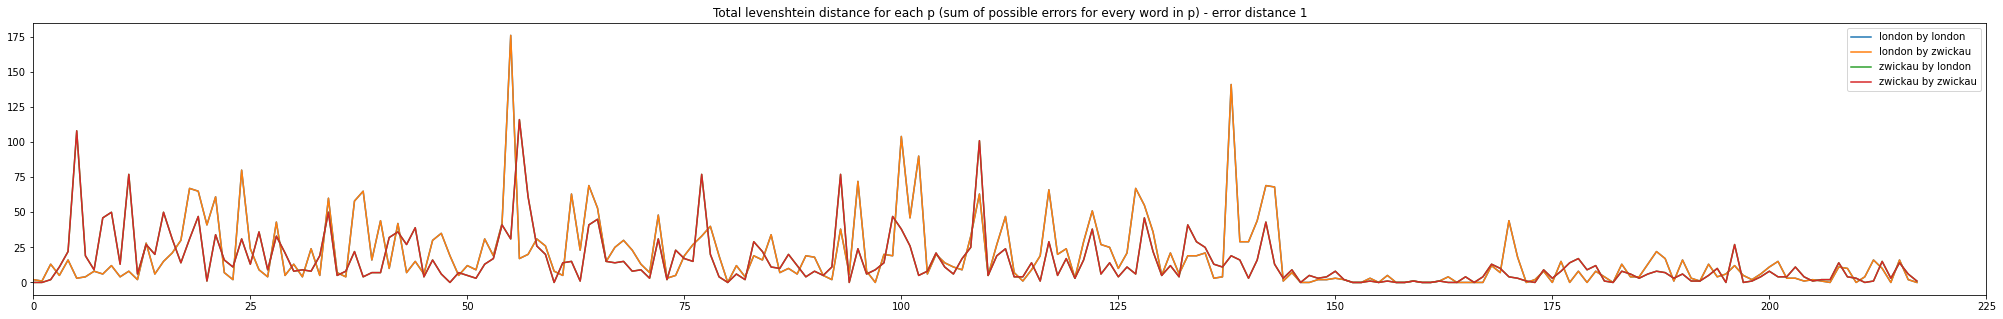

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(35,5))

ax.plot(london_chop_p_score_by_london, label='london by london')
ax.plot(london_chop_p_score_by_zwickau, label='london by zwickau')
ax.plot(zwickau_chop_p_score_by_london, label='zwickau by london')
ax.plot(zwickau_chop_p_score_by_zwickau, label='zwickau by zwickau')


ax.set_xlim([0, 225])
ax.set_title('Total levenshtein distance for each p (sum of possible errors for every word in p) - error distance 1')
ax.legend()

In [ ]:
london_chop_p_score_by_london[55]

In [ ]:
london_chop_corpus[55]

In [ ]:
london_chop_corpus

In [ ]:
zwickau_chop_corpus[55]

In [ ]:
london_chop_p_score_by_london[138]

In [ ]:
london_chop_corpus[138]

In [ ]:
zwickau_chop_corpus[138]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35,5))

# ax.plot([ p / len(london_chop_corpus[i].split()) if len(london_chop_corpus[i].split()) > 0 else 0 for i, p in enumerate(london_chop_p_score_by_london)], label='london by london')
# ax.plot([ p / len(london_chop_corpus[i].split()) if len(london_chop_corpus[i].split()) > 0 else 0 for i, p in enumerate(london_chop_p_score_by_zwickau)], label='london by zwickau')
ax.plot([ p / len(zwickau_chop_corpus[i].split()) if len(zwickau_chop_corpus[i].split()) > 0 else 0 for i, p in enumerate(zwickau_chop_p_score_by_london)], label='zwickau by london')
ax.plot([ p / len(zwickau_chop_corpus[i].split()) if len(zwickau_chop_corpus[i].split()) > 0 else 0 for i, p in enumerate(zwickau_chop_p_score_by_zwickau)], label='zwickau by zwickau')


ax.set_xlim([0, 225])
ax.set_title('Normalized to p len: Total levenshtein distance for each p (sum of possible errors for every word in p) - error distance 1')
ax.legend()

In [ ]:
zwickau_chop_p_score_by_london

In [ ]:
for i, p in enumerate(london_chop_p_score_by_london):
    if len(london_chop_corpus[i].split()) == 0:
        print(f'found zero lenght', i)
        print(london_chop_corpus[i])

In [ ]:
london_chop_corpus[150: 157]

In [ ]:
london_chop_p_score_by_london[157]

In [ ]:
possible_mistakes_london_chop_by_burchard_based_on_london_corpus_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    london_chop_corpus,
    burchard_based_on_london_corpus,
    error_threshold = 1
)

In [ ]:
possible_mistakes_zwickau_chop_by_burchard_based_on_london_corpus_distance_1 = thesisLevenshteinSimilarities.create_version_possible_errors_mapping(
    zwickau_chop_corpus,
    burchard_based_on_london_corpus,
    error_threshold = 1
)

In [ ]:
zwickau_chop_corpus

In [ ]:
possible_mistakes_london_chop_by_burchard_based_on_london_corpus_distance_1

In [ ]:
print(len(thesisLevenshteinSimilarities.get_non_empty_alternatives(possible_mistakes_london_chop_by_burchard_based_on_london_corpus_distance_1)))
print(len(thesisLevenshteinSimilarities.get_non_empty_alternatives(possible_mistakes_zwickau_chop_by_burchard_based_on_london_corpus_distance_1)))

In [ ]:
thesisLevenshteinSimilarities.get_non_empty_alternatives(possible_mistakes_london_chop_by_burchard_based_on_london_corpus_distance_1)

In [ ]:
thesisLevenshteinSimilarities.get_non_empty_alternatives(possible_mistakes_zwickau_chop_by_burchard_based_on_london_corpus_distance_1)

# chop lenghts by p
this is might be indication to in which part of text there is mo similarity than in another

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35,5))

ax.plot([len(i) for i in thesisDataReader.get_burchard_candidate_version_based_on_strongly_similar_london_base()], label='burchard')
ax.plot([len(i) for i in london_chop_corpus], label='london chop')
ax.plot([len(i) for i in zwickau_chop_corpus], label='zwickau chop')

ax.set_title('p lenght')
ax.set_xlim([0, 225])
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35,5))

ax.plot([len(i) for i in thesisDataReader.get_burchard_candidate_version_based_on_strongly_similar_london_base()], label='burchard')
ax.plot([len(i) for i in london_chop_corpus], label='london chop')
ax.plot([len(i) for i in zwickau_chop_corpus], label='zwickau chop')

ax.set_title('p lenght')
ax.set_xlim([0, 225])
ax.legend()
ax.set_yscale('log')


In [ ]:
len(thesisDataReader.get_burchard_candidate_version_based_on_strongly_similar_london_base())

In [ ]:
possible_mistakes_burchard_based_on_london_distance_1

In [ ]:
possible_mistakes_burchard_based_on_zwickau_distance_1

In [31]:
for i in possible_mistakes_burchard_based_on_london_distance_1:
    if len(possible_mistakes_burchard_based_on_london_distance_1[i]) == 0 and len(possible_mistakes_burchard_based_on_zwickau_distance_1[i]) == 0: continue
    
    for n, p in enumerate(possible_mistakes_burchard_based_on_london_distance_1[i]):
        if p[0] != possible_mistakes_burchard_based_on_zwickau_distance_1[i][n][0]:
            print('found mismatch', p)